<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [106]:
data = pd.read_csv('../../train-balanced-sarcasm.csv')

In [107]:
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [5]:
data.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [6]:
data['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

Let's split data into train, validation and test sets.

In [8]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(data['comment'], data['label'], random_state=17)

## 1. Analyzing dataset

Let's first analyze authors. Here we printing two most 'sarcastic' and two less 'sarcastic' authors with more than 100 comments

In [32]:
authors_mean = data.groupby('author')['label'].agg([np.size, np.mean])
authors_mean[authors_mean['size'] > 100].sort_values(by='mean', ascending=False).iloc[np.r_[0:2, -2:0]]

,size,mean
author,,
AudibleNod,142,0.500000
ivsciguy,342,0.500000
indoninja,106,0.490566
radpandaparty,104,0.490385


Well, seems like no insight in authors. Now let's do the same with subreddits

In [91]:
subreddits_mean = data.groupby('subreddit')['label'].agg([np.size, np.mean])
subreddits_mean[subreddits_mean['size'] > 1000].sort_values(by='mean', ascending=False).iloc[np.r_[0:5, -5:0]]

,size,mean
subreddit,,
creepyPMs,5466,0.784303
MensRights,3355,0.680775
ShitRedditSays,1284,0.661994
worldnews,26376,0.642516
Libertarian,2562,0.640125
BlackPeopleTwitter,1831,0.379574
science,1126,0.377442
aww,2493,0.315684
4chan,1074,0.245810


Seems like some subreddit more 'sarcastic' than others. Let's build plot for score

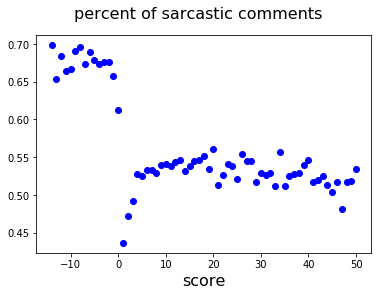

In [96]:

score_means = data.groupby(['score'])['label'].agg([np.size, np.mean])
score_means = score_means[score_means['size'] > 500]['mean']

fig = plt.figure()

fig.suptitle('percent of sarcastic comments', fontsize=16)
plt.xlabel('score', fontsize = 16)

plt.plot(score_means.index, score_means.values, 'bo')
plt.show()

Seems like more 'sarcastic' comments usually get lower scores

Now let us look at the frequently occuring words in the data by creating a word cloud.

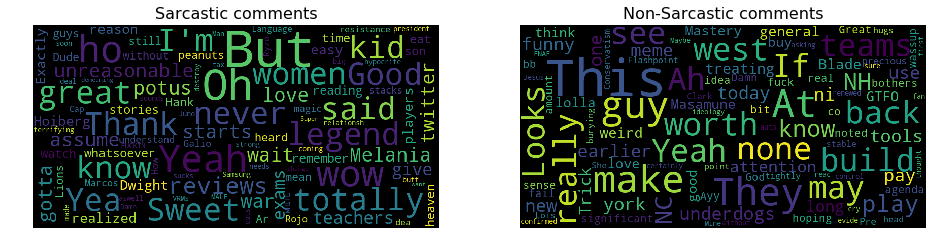

In [90]:
from wordcloud import WordCloud, STOPWORDS

wordcloud = WordCloud(background_color='black',
                stopwords = STOPWORDS,
                max_words = 100,
                max_font_size = 100, 
                random_state = 42,
                width=800, 
                height=400,
                mask = None)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title('Sarcastic comments', fontsize=16)
plt.axis('off')
wordcloud.generate(str(data.loc[data['label'] == 1, 'comment']))
plt.imshow(wordcloud);  


plt.subplot(1, 2, 2)
plt.title('Non-Sarcastic comments', fontsize=16)
plt.axis('off')
wordcloud.generate(str(data.loc[data['label'] == 0, 'comment']))
plt.imshow(wordcloud);  

plt.show()


How about length of comments

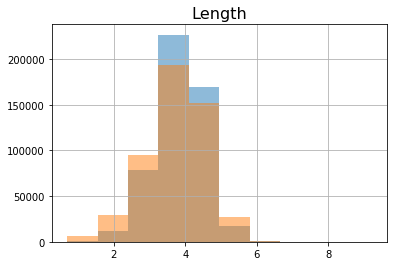

In [104]:
plt.title('Length', fontsize=16)
sarcastic_len = data.loc[data['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
non_sarcastic_len = data.loc[data['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='non-sarcastic', alpha=.5)




## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions